# Contextuailzed Embeddings
Having a dataframe of sentences that contain a term, create the contextualized embeddings of the uses of that term in the sentences with a transformers model.

In [10]:
import os
from transformers import pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load the language model

In [11]:
path2model = "bert-base-uncased" # os.path.join(os.pardir, "histLM_dataset", "bert", "bert_1760_1900")
tokenizer = "bert-base-uncased"

In [12]:
model = pipeline("feature-extraction", 
                    model=path2model, 
                    tokenizer=tokenizer)

## Load the sentences

In [13]:
datapath = '../../sentences_out'

term = 'fair'
df_sentences = pd.read_csv(os.path.join(datapath, term+'.csv'))
df_sentences['sentence_lc'] = df_sentences['sentence'].str.lower()

In [14]:
print(df_sentences.shape)
df_sentences.head()

(425, 5)


,year,genre,id,sentence,sentence_lc
0,1889,news,672250,Because of the revolutionary character of the ...,because of the revolutionary character of the ...
1,1889,news,672250,"It has been observed , of course , that the No...","it has been observed , of course , that the no..."
2,1889,news,672250,"Originally , the Post 's opposition to the fai...","originally , the post 's opposition to the fai..."
3,1889,news,672250,for by the astute @ @ @ @ @ @ @ @ @ @ a ' perf...,for by the astute @ @ @ @ @ @ @ @ @ @ a ' perf...
4,1889,news,672250,about the fair .,about the fair .


## Apply model to get embeddings
This will take some time to run

In [15]:
# embedding on each sentence
embeddings = model(list(df_sentences['sentence_lc']))

In [16]:
def get_word_embeddings(embedding, sentence, query):
    """
    Only retrieve the embeddings for the tokens that match the query
    Does not yet handle the case where query is split up in tokenization.
    """
    token_ids = model.tokenizer(sentence)
    tokens = model.tokenizer.convert_ids_to_tokens(token_ids['input_ids'])
    query_embeddings = np.array([embedding[i] for i,tok in enumerate(tokens) if tok==query])
    return query_embeddings

In [17]:
# Now do this for all sentences, and put them together in a dataframe
df_embeddings = pd.DataFrame()
for i, (_, row) in enumerate(df_sentences.iterrows()):
    emb = get_word_embeddings(embeddings[i], row['sentence'], term)
    df_embeddings = df_embeddings.append(pd.DataFrame({
        'sentence': row['sentence'],
        'year': row['year'],
        'genre': row['genre'],
        'id': row['id'],
        'embedding': list(emb)}))

In [18]:
df_embeddings = df_embeddings.reset_index()

## Plot PCA

In [19]:
from sklearn.decomposition import PCA

In [20]:
pca = PCA(n_components=2)

In [21]:
X = np.array([e for e in df_embeddings['embedding']])
X.shape

(433, 768)

In [22]:
X_pca = pca.fit_transform(X)

In [23]:
df_embeddings['pca1'] = X_pca[:,0]
df_embeddings['pca2'] = X_pca[:,1]

Text(0.5, 1.0, 'PCA colored per genre')

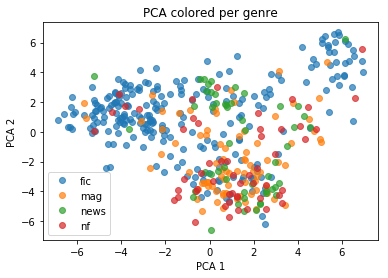

In [24]:
for key, group in df_embeddings.groupby(['genre']):
    plt.plot(group.pca1, group.pca2, 'o', alpha=0.7, label=key)
plt.legend()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title("PCA colored per genre")

## Masked word prediction

In [25]:
model_masked = pipeline('fill-mask',
                           model=path2model, 
                    tokenizer=tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
outputs = []

for i in range(len(df_sentences)):
    sent = df_sentences['sentence_lc'][i]
    sent_masked = sent.replace(term, '[MASK]', 1)
    output = model_masked(sent_masked)
    outputs.append(output)
    

predicted_words = [[o['token_str'] for o in output] for output in outputs]

predicted_words_df = pd.DataFrame(predicted_words, columns = ['word_{}'.format(i+1) for i in range(5)])
df = pd.concat([df_sentences, predicted_words_df], axis=1)

In [27]:
all_words = pd.concat([df['word_{}'.format(i+1)] for i in range(5)])
all_words.value_counts().head(30)

fair          117
good           89
great          37
beautiful      37
right          29
reasonable     29
little         28
true           28
the            27
young          26
small          23
own            21
new            20
a              20
clear          19
better         16
free           14
high           14
certain        13
it             13
me             13
full           13
proper         13
safe           12
possible       12
long           12
"              12
lovely         11
large          11
easy           11
dtype: int64